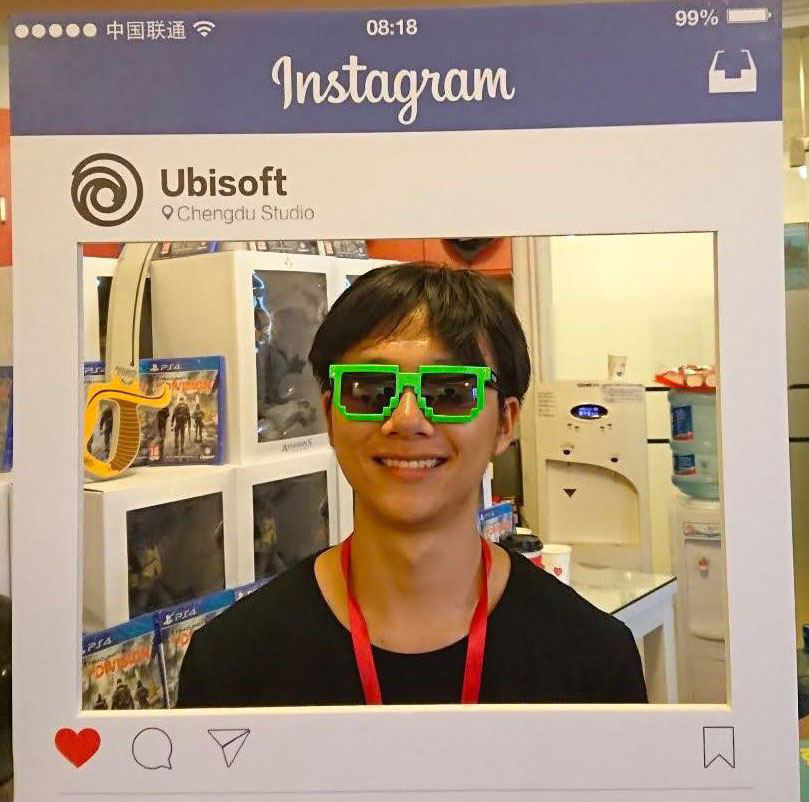

In [11]:
import torch
from PIL import Image
import requests

url = "https://huzeyann.github.io/assets/img/prof_pic_old.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [12]:
from einops import rearrange
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
import numpy as np


def feature_extractor(images, resolution=(448, 448), layer=11):
    if isinstance(images, list):
        assert isinstance(images[0], Image.Image), "Input must be a list of PIL images."
    else:
        assert isinstance(images, Image.Image), "Input must be a PIL image."
        images = [images]

    transform = transforms.Compose(
        [
            transforms.Resize(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    # extract DINOv2 last layer features from the image
    class DiNOv2Feature(torch.nn.Module):
        def __init__(self, ver="dinov2_vitb14_reg", layer=11):
            super().__init__()
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", ver)
            self.dinov2.requires_grad_(False)
            self.dinov2.eval()
            self.dinov2 = self.dinov2.cuda()
            self.layer = layer

        def forward(self, x):
            out = self.dinov2.get_intermediate_layers(x, reshape=True, n=np.arange(12))[self.layer]
            return out

    feat_extractor = DiNOv2Feature(layer=layer)

    feats = []
    for i, image in enumerate(images):
        torch_image = transform(image)
        feat = feat_extractor(torch_image.unsqueeze(0).cuda()).cpu()
        feat = feat.squeeze(0).permute(1, 2, 0)
        feats.append(feat)
    feats = torch.stack(feats).squeeze(0)
    return feats

In [13]:
feat = feature_extractor(image, resolution=(448, 448), layer=9)

Using cache found in /home/andrew/.cache/torch/hub/facebookresearch_dinov2_main


In [14]:
# apply ncut to the features, each patch of pixels (token) is a node
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'ncut_pytorch'))
from ncut_pytorch import NCUT

h, w, c = feat.shape
print("Feature shape:", feat.shape)  # "Feature shape: torch.Size([32, 32, 768])

n = h * w  # flatten the pixels into nodes
feat = feat.reshape(n, c)
model = NCUT(num_eig=20)
eigenvectors, eigenvalues = model.fit_transform(feat)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Feature shape: torch.Size([32, 32, 768])
Eigenvalues: tensor([1.0000, 0.0978, 0.0871, 0.0770, 0.0594, 0.0380, 0.0306, 0.0266, 0.0200,
        0.0185, 0.0168, 0.0156, 0.0149, 0.0126, 0.0122, 0.0117, 0.0107, 0.0097,
        0.0091, 0.0080])
Eigenvectors shape: torch.Size([1024, 20])


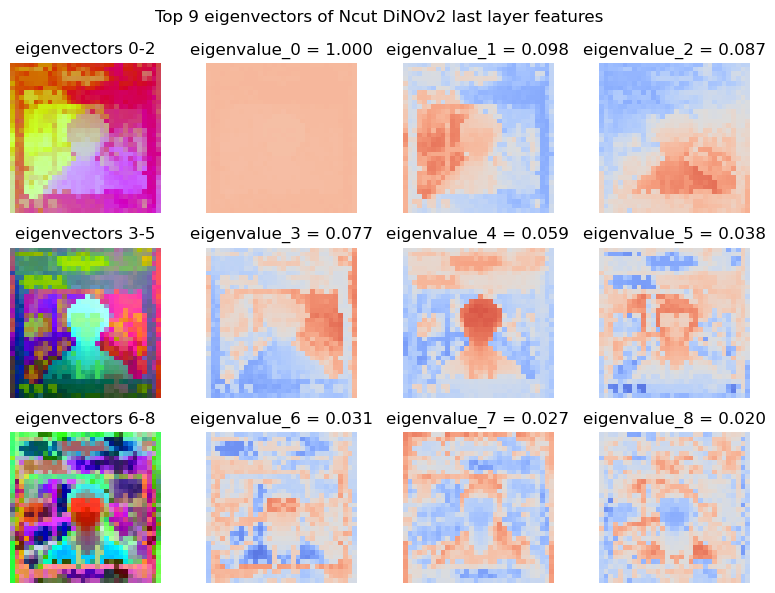

In [15]:
# visualize top 9 eigenvectors, 3 eigenvectors per row
import matplotlib.pyplot as plt
from ncut_pytorch import quantile_normalize
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
i_eig = 0
for i_row in range(3):
    for i_col in range(1, 4):
        ax = axs[i_row, i_col]
        ax.imshow(eigenvectors[:, i_eig].reshape(h, w), cmap="coolwarm", vmin=-0.1, vmax=0.1)
        ax.set_title(f"eigenvalue_{i_eig} = {eigenvalues[i_eig]:.3f}")
        ax.axis("off")
        i_eig += 1
for i_row in range(3):
    ax = axs[i_row, 0]
    start, end = i_row * 3, (i_row + 1) * 3
    rgb = quantile_normalize(eigenvectors[:, start:end]).reshape(h, w, 3)
    ax.imshow(rgb)
    ax.set_title(f"eigenvectors {start}-{end-1}")
    ax.axis("off")
plt.suptitle("Top 9 eigenvectors of Ncut DiNOv2 last layer features")
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt


def plot_3d_animation(X_3d, rgb, title):
    x, y, z = X_3d.T
    fig = plt.figure(figsize=(10, 5))

    # Add a subplot for the static image
    ax1 = fig.add_subplot(121)
    ax1.imshow(rgb.reshape(h, w, 3))
    ax1.axis('off')  # Hide axes

    # Add a subplot for the 3D scatter plot
    ax = fig.add_subplot(122, projection='3d')
    scat = ax.scatter(x, y, z, c=rgb, s=10)

    # set ticks labels
    ax.set_xlabel("Dimension #1")
    ax.set_ylabel("Dimension #2")
    ax.set_zlabel("Dimension #3")

    # set ticks, labels to none
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    z_ticks = ax.get_zticks()
    labels = ["" for _ in range(len(x_ticks))]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_zticklabels(labels)

    plt.suptitle(title)
    plt.show()
    
    # Define the update function for the animation
    def update(frame):
        if frame <= 360:
            ax.view_init(elev=10., azim=frame)
        if frame > 360 and frame <= 720:
            ax.view_init(elev=frame-360, azim=10.)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 3), interval=60)
    from IPython.display import HTML
    html = HTML(ani.to_jshtml())
    display(html)
    
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X_3d, rgb, title):
    x, y, z = X_3d.T
    fig = plt.figure(figsize=(8, 4))

    # Add a subplot for the static image
    ax1 = fig.add_subplot(121)
    ax1.imshow(rgb.reshape(h, w, 3))
    ax1.axis('off')  # Hide axes

    # Add a subplot for the 3D scatter plot
    ax = fig.add_subplot(122, projection='3d')
    scat = ax.scatter(x, y, z, c=rgb, s=10)

    # set ticks labels
    # ax.set_xlabel("Dimension #1")
    # ax.set_ylabel("Dimension #2")
    # ax.set_zlabel("Dimension #3")

    # set ticks, labels to none
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    z_ticks = ax.get_zticks()
    labels = ["" for _ in range(len(x_ticks))]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_zticklabels(labels)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [27]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

def cluster_and_dbi(points: np.ndarray, k: int) -> float:
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(points)
    
    # Get cluster labels from K-Means
    labels = kmeans.labels_
    
    # Calculate Davies-Bouldin Index
    dbi = davies_bouldin_score(points, labels)
    
    return dbi


def cluster_and_silhouette(points: np.ndarray, k: int) -> float:
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(points)
    
    # Get cluster labels from K-Means
    labels = kmeans.labels_
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(points, labels)
    
    return silhouette_avg

/home/andrew/miniconda3/envs/ofa/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_383139/216401551.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_383139/216401551.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/tmp/ipykernel_383139/216401551.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels)
/tmp/ipykernel_383139/216401551.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made larg

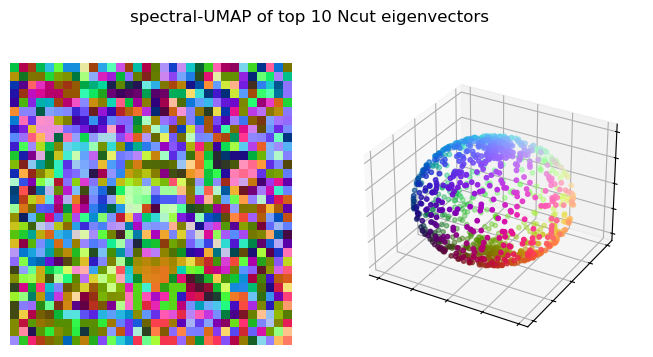

In [28]:
# use t-SNE or UMAP to visualize the top 10 eigenvectors in one plot
# from ncut_pytorch import nystrom_tsne, nystrom_umap, quantile_normalize
from ncut_pytorch import rgb_from_umap_sphere

X_3d, rgb = rgb_from_umap_sphere(eigenvectors[:, :10], device="cpu", n_neighbors=100, min_dist=0.1)
# plot_3d(X_3d, rgb, "3D spectral-UMAP of top 9 Ncut eigenvectors from DiNOv2 last layer features\n each dot is a patch of pixels (ViT tokens) \n each pixel on the left corresponds to a dot on the right")
plot_3d(X_3d, rgb, "spectral-UMAP of top 10 Ncut eigenvectors")

In [29]:
print(cluster_and_dbi(X_3d, 10))            # Lower is better
print(cluster_and_silhouette(X_3d, 10))     # Higher is better

0.8801477569825122
0.3649255


/tmp/ipykernel_383139/216401551.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_383139/216401551.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/tmp/ipykernel_383139/216401551.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels(labels)
/tmp/ipykernel_383139/216401551.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


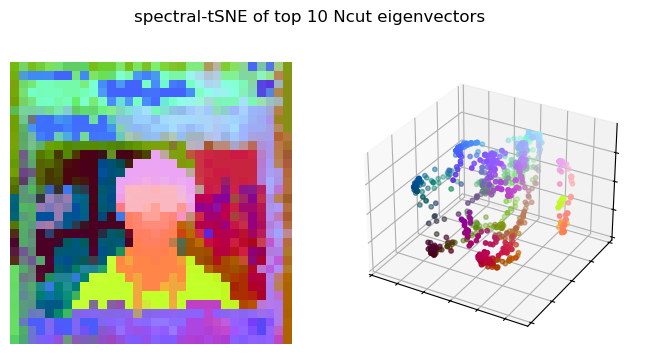

In [31]:
from ncut_pytorch import rgb_from_tsne_3d

X_3d, rgb = rgb_from_tsne_3d(eigenvectors[:, :10], device="cpu", perplexity=100)
# plot_3d(X_3d, rgb, "3D spectral-tSNE of top 9 Ncut eigenvectors from DiNOv2 last layer features\n each dot is a patch of pixels (ViT tokens) \n each pixel on the left corresponds to a dot on the right")
plot_3d(X_3d, rgb, "spectral-tSNE of top 10 Ncut eigenvectors")

In [32]:
print(cluster_and_dbi(X_3d, 10))            # Lower is better
print(cluster_and_silhouette(X_3d, 10))     # Higher is better

0.7562946051137359
0.47995886
